# Results 

## Table of contents

+ [Notebook setup](#notebook-setup)
+ [General remarks](#general-remarks)
+ [Final models](#final-models)
    + Short term outcome
    + Long term outcome
+ [Limitations and future work](#limitations-and-future-work)
+ [Conclusion](#conclusion)

-----

## Notebook setup

In [1]:
import pandas as pd
import numpy as np
from functions import helper
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# setting figuresize and label size globally
plt.rcParams['figure.figsize']=(12,8)
plt.rcParams['font.size']=14

sns.set_theme(palette = 'pastel', 
              font_scale=1.25)

----
## General remarks

In the beginning we defined "Recall" (of True) as our target. If we would have solely decided on a model with high recall (such as the Logistic Regression with adjusted threshold), we would have gotten a model that predicts all patients with poor health correctly. But it is very likely that this model will also predict that all other patients will have a poor health outcome. In that case, we would not need a model for prediction. Hence, for the final model we also considered the accuracy of the model. 

Logistic Regression was the best model to predict the short term outcome of stroke patients (recall = 73%), with a fairly reasonable accuracy (70%). For the prediction of the long term of stroke patients, Random Forest was the best model (recall = 89%, accuracy = 76%). Below we have summarized these two models again.

## Final models



In [2]:
# encoder for categories
onehot = OneHotEncoder(drop="first")

# scalers for numerical features
mms = MinMaxScaler()
ss = StandardScaler()

# Prepare list of numerical and categorical columns
num_cols = make_column_selector(dtype_include=np.number)
cat_cols = make_column_selector(dtype_include='category')

### Short term outcome

In [3]:
# get the data
df = pd.read_csv('data/IST_corrected_clean.csv',  index_col= [0])

# Reset the index
df.index = pd.RangeIndex(len(df.index))

# drop missing values from 'RATRIAL'
df = df.dropna(subset = ['RATRIAL'])

# transform target into 1/0 
df['DDEAD'] = df.DDEAD == 'Y'

# Select features
features = ['AGE', 'RSBP', 'SEX', 'RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 'RATRIAL']
X = df[features]

# Select target
y = df.DDEAD

In [4]:
# Split the data in test and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
#convert all 'objects' into 'categories'
X_train = pd.concat([
        X_train.select_dtypes([], ['object']),
        X_train.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(X_train.columns, axis=1)

In [6]:
#convert all 'objects' into 'categories' 
X_test = pd.concat([
        X_test.select_dtypes([], ['object']),
        X_test.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(X_test.columns, axis=1)

In [7]:
# Define transformer
transformer = ColumnTransformer([
    ("scale", mms, num_cols),
    ("encode", onehot, cat_cols),
])

# Transform
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)

# Oversmapling and Undersampling
sme = SMOTEENN(random_state= 42)
X_train_trans_r, y_train_r = sme.fit_resample(X_train_trans, y_train)

In [8]:
# Calculate the LogisticRegression
logreg = LogisticRegression(max_iter=400, random_state= 42)
logreg_pipe = make_pipeline(sme, logreg)

              precision    recall  f1-score   support

       False       0.96      0.70      0.80      4797
        True       0.21      0.72      0.33       550

    accuracy                           0.70      5347
   macro avg       0.58      0.71      0.57      5347
weighted avg       0.88      0.70      0.76      5347

[[3334 1463]
 [ 153  397]]
Misclassified samples: 1616
F1-Score : 0.3295


(Pipeline(steps=[('smoteenn', SMOTEENN(random_state=42)),
                 ('logisticregression',
                  LogisticRegression(max_iter=400, random_state=42))]),
 array([ True, False,  True, ..., False, False, False]))

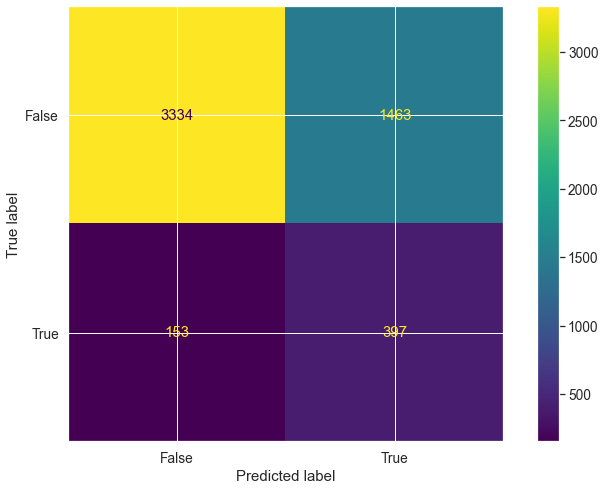

In [9]:
helper.pred_model(logreg_pipe, X_train_trans_r, X_test_trans, y_train_r, y_test)

This was the model with the best recall (and accuracy). Let's have a closer look at the features. Which are the most important ones?

In [10]:
X_train_trans = pd.DataFrame(X_train_trans)

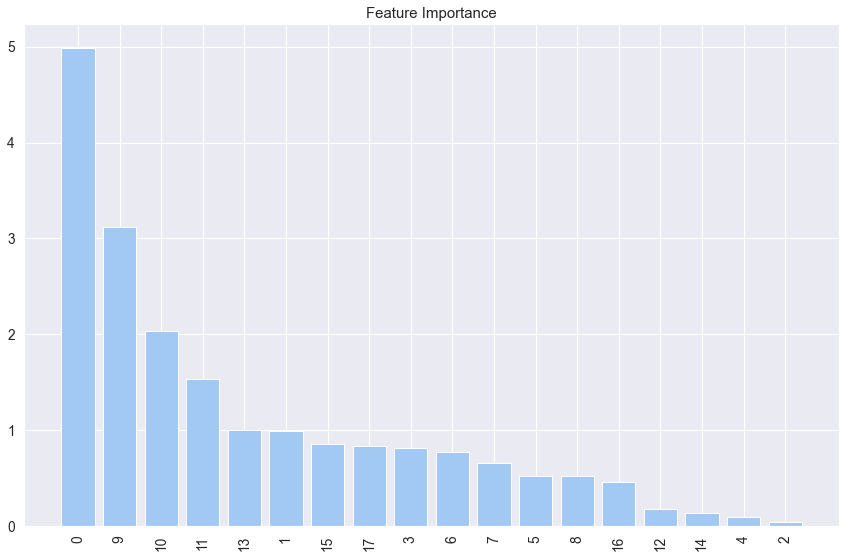

In [11]:
importances = abs(logreg.coef_[0])

# Sort the feature importance in descending order
sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(X_train_trans.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train_trans.shape[1]), X_train_trans.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

Encoded | Original 
 :-- | --:
 0 | AGE
 1 | RSBP
 2 | SEX
 3, 4 | RDEF1
 5, 6 | RDEF2
 7, 8 | RDEF3
 9, 10 | RDEF4
 11, 12 | RDEF5
 13, 14 | RDEF6
 15, 16 | RDEF7
 17 | RATRIAL

When converting the numerical and categorical data, we first used the numerical ones. Thus feature 0 is AGE and feature 1 is RSBP. In this regard, the following features are the categorical ones but encoded. 

The most important features for this model are age and severe deficits (dysphasia, hemianopia, visuospatial disorder) as well as blood pressure (to some extent).

### Long term outcome

The best model to predict the long term outcome was Random Forest. We will set it up again and check which features are the most important ones for the prediction.


In [13]:
# Get the data
df = pd.read_csv('data/IST_corrected_clean.csv',  index_col= [0])

# Reset the index
df.index = pd.RangeIndex(len(df.index))

# drop all participants that passed away within 14 days
df = df[df['DDEAD'] != 'Y']

In [14]:
def target(row):
    if row.OCCODE == 'Recovered':
        return 0
    elif row.OCCODE in ['Not recovered', 'Dependent', 'Dead']:
        return 1
    else:
        return np.nan

In [15]:
# Create the new target column
df['NOREC'] = df.apply(lambda row: target(row), axis=1)

In [16]:
# drop missing values from 'RATRIAL'
df = df.dropna(subset = ['RATRIAL'])

In [17]:
# convert NCB14 and STRK14 into categoricals
df['NCB14'] = df.NCB14.astype('object')
df['STRK14'] = df.STRK14.astype('object')

# Select features
features = ['SEX', 'AGE', 'RSBP', 'RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 'NCB14', 'STRK14', 'RATRIAL']
X = df[features]

# Select target NOREC
y = df.NOREC

In [18]:
# Split the data in test and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
#convert all 'objects' into 'categories'
X_train = pd.concat([
        X_train.select_dtypes([], ['object']),
        X_train.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(X_train.columns, axis=1)

In [20]:
#convert all 'objects' into 'categories' 
X_test = pd.concat([
        X_test.select_dtypes([], ['object']),
        X_test.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(X_test.columns, axis=1)

In [21]:
# oversampling and undersampling
sme = SMOTEENN(random_state= 42)

In [22]:
# Encode categorical features
X_train_trans = X_train.copy()
X_test_trans = X_test.copy()
for cat in ['SEX', 'RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 'RATRIAL', 'NCB14', 'STRK14']:
    X_train_trans[[cat]] = X_train_trans[cat].cat.codes
    X_test_trans[[cat]] = X_test_trans[cat].cat.codes

              precision    recall  f1-score   support

           0       0.29      0.19      0.23       921
           1       0.82      0.89      0.86      3862

    accuracy                           0.76      4783
   macro avg       0.56      0.54      0.54      4783
weighted avg       0.72      0.76      0.73      4783

[[ 172  749]
 [ 417 3445]]
Misclassified samples: 1166
F1-Score : 0.8553


(RandomForestClassifier(class_weight='balanced', random_state=42),
 array([1, 0, 1, ..., 1, 1, 1]))

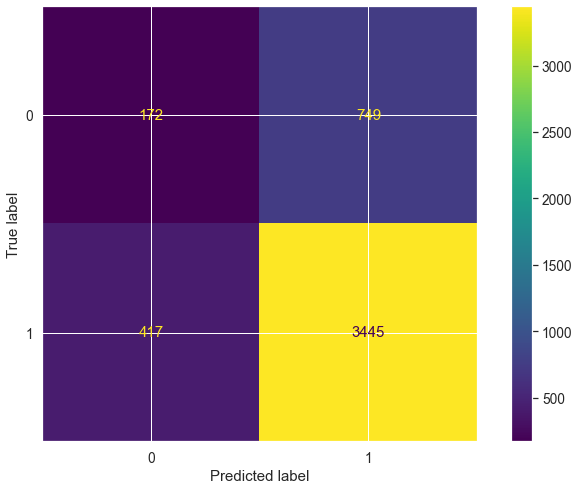

In [23]:
# Random Forest Classifier
rf_w = RandomForestClassifier(random_state = 42, class_weight= 'balanced')

helper.pred_model(rf_w, X_train_trans, X_test_trans, y_train, y_test)

This was the model with the best recall (and accuracy). Let's have a closer look at the features. Which are the most important ones?

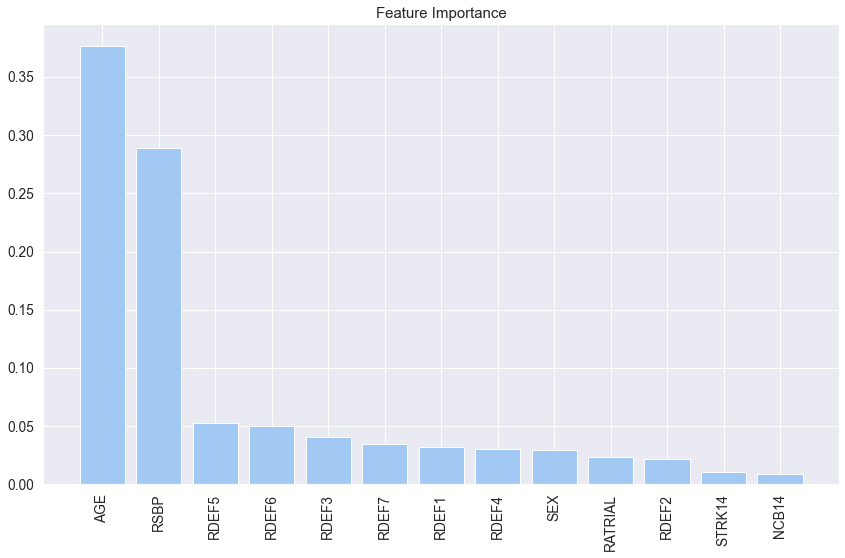

In [24]:
importances = rf_w.feature_importances_

# Sort the feature importance in descending order
sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

The most important features are the age and systolic blood pressure of the patient. These are followed by the sever deficits of hemianopia and visuospatial disorder as well as all other deficits that have about the same influence as sex and atrial fibrillation.

-----
## Limitations and future work

The dataset contains only a small number of features that may be able to predict the risk for patients to receive a recurrent stroke or other detrimental health conditions. Strokes are known to be influenced by high blood pressure (which was included in the data), though smoking poses a high risk for patients. In fact, women are particularly prone to strokes if they smoke and use certain birth control medicines ([source](https://www.cdc.gov/stroke/women.htm)). People who tend to be obese and or have a high blood sugar are also at risk.

The International Stroke Trial has been continued and also extended in terms of variables. It is worth to look into the dataset. More information can be found [here](https://www.ed.ac.uk/clinical-brain-sciences/research/completed-studies-trials/ist-3-trial). 

The models we have built did not account for the treatment these patients received. Primarily, because it did not have much effect. However, about 25 years have passed since the first International Stroke Trial has been conducted. Surely, there are new insights and treatments for stroke patients. It is worth looking into the possibility to include treatment as a feature (once the data is available).

The models itself are limited as both predict a fair number of patients with a better health as having poor health. Here, more data and possibly other techniques, like neuronal network, may help to increase the correct predictions.

------

## Conclusion

We were able to build one model to predict the short term and one model to predict the long term outcome of stroke patients. Both models were primarily driven by the age of the participants. In both models, dysphasia, hemianopia, visuospatial disorder, systolic blood pressure had an effect, but to differing degrees.

Once more detailed data has been added to the models, these may be implemented as a decision support tool for medical teams.